In [8]:
!pip install Arabic-Stopwords

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from sklearn.metrics import classification_report ,confusion_matrix ,accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import TreebankWordTokenizer
from keras.preprocessing.text import Tokenizer
import arabicstopwords.arabicstopwords as stp
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from keras import layers
import seaborn as sns
import pandas as pd
import collections
import numpy as np
import matplotlib
import argparse
import codecs
import string
import pickle
import nltk
import math 
import sys
import re
import os
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
root_path = '/content/drive/MyDrive/Colab Notebooks/Tasks/questions classification by topic'
data_path = '/content/drive/MyDrive/Colab Notebooks/Tasks/questions classification by topic/DataSets'
results_path = '/content/drive/MyDrive/Colab Notebooks/Tasks/questions classification by topic/results'
# results_path = '/content/drive/MyDrive/Colab Notebooks/Tasks/questions classification by topic/result_with_deep_learning'

# Dataset Preparation (pre-processing)

In [12]:
data = pd.read_csv(os.path.join(data_path,'after_collection_IslamWebAR&FullArabicData_v2.csv'))

In [13]:
print(data.shape)
data.head()

(43771, 2)


,Question,Main Topic
0,هل هذا حديث يجوز الاستشهاد به قال رسول الله صل...,الحديث الشريف
1,ما صحة قراءة خمس آيات صباحا ومساء فيها خمسون ق...,الأذكار والأدعية
2,مات أبي ولم يكن له أبناء غيري (أنا أنثى بالغة)...,الفقه وفروعه
3,أنا طالبة في الثانوية العامة، أنعم عليّ الله س...,التربية و الآداب
4,بسم الله الرحمن الرحيمالسؤال/ من ماذا خلق الله...,الأطعمة والأشربة والصيد


In [14]:
data['Main Topic'].value_counts()

الفقه وفروعه                20179
التربية و الآداب            11331
القرآن و علومه               2818
العقيدة الإسلامية            2751
العلم و الدعوة               2413
الحديث الشريف                1670
التراجم والأخبار              748
التاريخ و السيرة النبوية      534
الأذكار والأدعية              496
مشكلات اجتماعية وفكرية        447
الأطعمة والأشربة والصيد       342
السياسة الشرعية                42
Name: Main Topic, dtype: int64

In [15]:
print(len(data['Main Topic'].tolist()))
list_of_label = list(set(data['Main Topic'].tolist()))
len(list_of_label)

43771


12

In [16]:
def isNaN(string):
    if string == string:
        return string
    return "nan"

In [17]:
data['Question'] = data['Question'].apply(isNaN)
data[data['Question']=='nan'].shape

(0, 2)

In [18]:
print(len(data['Main Topic'].tolist()))
list_of_label = list(set(data['Main Topic'].tolist()))
len(list_of_label) 

43771


12

In [19]:
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

In [20]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

In [21]:
def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text

In [22]:
def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [23]:
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [24]:
def clean_text(text):
    text = remove_diacritics(text)
    text = remove_punctuations(text)
    text = remove_repeating_char(text)
    text = re.sub(r"([@A-Za-z0-9_ـــــــــــــ]+)|[^\w\s]|#|http\S+", " ", text)
    text = " ".join([word for word in text.split() if not stp.is_stop(u"{}".format(word))])
    text = " ".join([word for word in text.split() if len(word)>2])
    return text

In [25]:
data['Question'] = data['Question'].apply(clean_text)

In [26]:
data.head(3)

,Question,Main Topic
0,حديث يجوز الاستشهاد قال رسول اله صلى اله وسلم ...,الحديث الشريف
1,صحة قراءة خمس آيات صباحا خمسون قافا لتحصين وال...,الأذكار والأدعية
2,مات يكن أبناء أنثى بالغةورثته وعمي الأول شقيق ...,الفقه وفروعه


In [27]:
def marg(text):
    return " ".join([sen for sen in text]) if type(text) is list else text

In [28]:
X_train = []
y_train = []
X_test = []
y_test = []
labels = []
for label in list_of_label:
    # if len(data[data['Main Topic']==label]['Question'].tolist())<1500:
    #   continue
    x = []
    y = []
    labels.append(label)
    xT1 = data[data['Main Topic']==label]['Question'].tolist()
    yT1_ = data[data['Main Topic']==label]['Main Topic'].tolist()
    yT1 = [1 for _ in range(len(yT1_))]
    for l in list_of_label:
        if l == label:
            continue
        LENGTH = len(data[data['Main Topic']==l]['Question'].tolist())
        p = math.ceil((((len(xT1)*100)/data.shape[0])/100)*LENGTH) 
        xT2 = data[data['Main Topic']==l]['Question'].tolist()[:p]
        yT2_ = data[data['Main Topic']==l]['Main Topic'].tolist()[:p]
        x.append(xT2)
        y.append([0 for _ in range(len(yT2_))])
    xT2 = list(np.concatenate(x).flat)
    yT2 = list(np.concatenate(y).flat)
    TX_train , TX_test , Ty_train , Ty_test = train_test_split(list(np.concatenate([xT1,xT2]).flat),np.array(list(np.concatenate([yT1,yT2]).flat)),test_size=0.10,random_state=1000)
    X_train.append(TX_train)
    y_train.append(Ty_train)
    X_test.append(TX_test)
    y_test.append(Ty_test)

In [29]:
len(X_train)

12

In [30]:
for i,y in enumerate(y_train):
    print("=================","for data :",labels[i],"==================")
    print(len(y))
    elements_count = collections.Counter(y)
    for key, value in elements_count.items():
        print(f"{key}: {value}")

================= for data : التراجم والأخبار ==================
1340
0: 669
1: 671
================= for data : التربية و الآداب ==================
17760
1: 10209
0: 7551
================= for data : القرآن و علومه ==================
4914
1: 2546
0: 2368
================= for data : السياسة الشرعية ==================
80
1: 39
0: 41
================= for data : التاريخ و السيرة النبوية ==================
962
0: 472
1: 490
================= for data : العلم و الدعوة ==================
4229
1: 2163
0: 2066
================= for data : العقيدة الإسلامية ==================
4802
1: 2469
0: 2333
================= for data : الأذكار والأدعية ==================
892
0: 443
1: 449
================= for data : مشكلات اجتماعية وفكرية ==================
806
1: 404
0: 402
================= for data : الحديث الشريف ==================
2953
1: 1503
0: 1450
================= for data : الفقه وفروعه ==================
27954
1: 18152
0: 9802
================= for data : الأطعمة والأشربة والصيد ===========

In [31]:
for i,y in enumerate(y_test):
    print("=================","for data :",labels[i],"==================")
    print(len(y))
    elements_count = collections.Counter(y)
    for key, value in elements_count.items():
        print(f"{key}: {value}")

================= for data : التراجم والأخبار ==================
149
1: 77
0: 72
================= for data : التربية و الآداب ==================
1974
1: 1122
0: 852
================= for data : القرآن و علومه ==================
547
1: 272
0: 275
================= for data : السياسة الشرعية ==================
9
0: 6
1: 3
================= for data : التاريخ و السيرة النبوية ==================
107
0: 63
1: 44
================= for data : العلم و الدعوة ==================
470
1: 250
0: 220
================= for data : العقيدة الإسلامية ==================
534
0: 252
1: 282
================= for data : الأذكار والأدعية ==================
100
0: 53
1: 47
================= for data : مشكلات اجتماعية وفكرية ==================
90
0: 47
1: 43
================= for data : الحديث الشريف ==================
329
1: 167
0: 162
================= for data : الفقه وفروعه ==================
3107
1: 2027
0: 1080
================= for data : الأطعمة والأشربة والصيد ==================
69
0: 30
1: 39


In [32]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [33]:
def print_result(y_pred, y_test , title ,color):
    if len(y_test) < len(y_pred):
        y_pred = y_pred[: len(y_test)]
    elif len(y_test) > len(y_pred):
        y_test = y_test[: len(y_pred)]
    accuracy = accuracy_score(y_pred, y_test)
    classification_rep = classification_report(y_test, y_pred)
    con_matrix = confusion_matrix(y_test, y_pred)
    if len(con_matrix)==1:
        if len(con_matrix[0])==1:
            con_matrix = list(con_matrix)
            con_matrix[0] = list(con_matrix[0])
            con_matrix[0].append(0)
            con_matrix = np.array([con_matrix[0],[0,0]])
    plt.figure(figsize=(25,15))
    plt.subplot(2,1,1)
    group_names =['Not one']

    if y_test is np.ndarray:
      T1 = np.count_nonzero(y_test == 0) if np.count_nonzero(y_test == 0) !=0 else 1
      T2 = np.count_nonzero(y_test == 1)  if np.count_nonzero(y_test == 1) !=0 else 1
    else:
      T1 = y_test.tolist().count(0) if y_test.tolist().count(0)!=0 else 1
      T2 = y_test.tolist().count(1) if y_test.tolist().count(1)!=0 else 1
    group_counts = con_matrix
    group_percentages = np.round(con_matrix / np.array([[T1 , T1],[T2 , T2]]),3)
    t = 0.5
    plt.text(x=0.0 , y = 2.6, s =  "confusion_matrix :",fontsize=15)
    plt.text(x=0.0 , y = 3.3-t, s =  'Not one ',fontsize=15)
    plt.text(x=0.0 , y = 3.4-t, s =  'One ',fontsize=15)
    plt.text(x=0.3 , y = 3.2-t, s =  'Not one ',fontsize=15)
    plt.text(x=0.6 , y = 3.2-t, s =  'One',fontsize=15)
    plt.text(x=0.3 , y = 3.3-t, s =  "{}".format(con_matrix[0][0]),fontsize=15)
    plt.text(x=0.6 , y = 3.3-t, s =  "{}".format(con_matrix[0][1]),fontsize=15)
    plt.text(x=0.3 , y = 3.4-t, s =  "{}".format(con_matrix[1][0]),fontsize=15)
    plt.text(x=0.6 , y = 3.4-t, s =  "{}".format(con_matrix[1][1]),fontsize=15)
    sns.heatmap(group_percentages,xticklabels= ['Not one' , 'One'], yticklabels=['Not one' , 'One']  , annot=True, annot_kws={"size": 16},fmt='g', cmap=color)
    plt.title(title ,  fontsize = 18)
    plt.text(x =0,y = 2.3 , s = "accuracy  score on test : {}".format(accuracy),fontsize=15)    
    plt.text(x=0 , y = 3.9, s =  "classification_report :\n {}".format(classification_rep),fontsize=15)
    plt.xlabel("Predicted value")
    plt.ylabel("Real value")
    plt.savefig("{} .png".format(os.path.join(os.path.join(results_path,"Image"),title)))
    plt.show()

In [34]:
def tfidf_vectorizer(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

In [35]:
def count_vectorizer(data): # Bag of words (BOW)  , binary=True
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

In [36]:
def pad_sequences_vectorizer(X_train):
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
    X_train = pad_sequences(X_train, padding='post', maxlen=10000)
    input_Dim = X_train[0].shape
    return X_train,vocab_size,input_Dim,tokenizer

In [37]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [38]:
def train_models(v_X_train, y_train,save_model,labels): # X_train,
    svm =  SVC(kernel = 'rbf',probability=True).fit(v_X_train, y_train)
    save_model['SVM'][labels].append(svm)
    return svm

In [39]:
def evaluate_result(model,X_test,y_test,model_name,label,Container_Result,history):
    print("==========",model_name,"==========")
    y_predict = model.predict(X_test)
    print_result(y_predict, y_test , label ,color='Blues')
    if not (history is None):
      plot_history(history)

In [40]:
def Creat_Container_Result():
    Container_Result = {}
    Container_Result['SVM'] = {}
    for label in labels:
      Container_Result['SVM'][label] = []
    return Container_Result

In [41]:
labels

['التراجم والأخبار',
 'التربية و الآداب',
 'القرآن و علومه',
 'السياسة الشرعية',
 'التاريخ و السيرة النبوية',
 'العلم و الدعوة',
 'العقيدة الإسلامية',
 'الأذكار والأدعية',
 'مشكلات اجتماعية وفكرية',
 'الحديث الشريف',
 'الفقه وفروعه',
 'الأطعمة والأشربة والصيد']

### with TFIDF vectorizer 

In [42]:
save_model = {}
save_model['SVM'] = {}
for i in labels:
    save_model['SVM'][i] = []

*******************************************************************************************
****************************** result for data التراجم والأخبار ******************************
*******************************************************************************************
vectorizeation ....
training .....
evaluation ....
========== SVM ==========


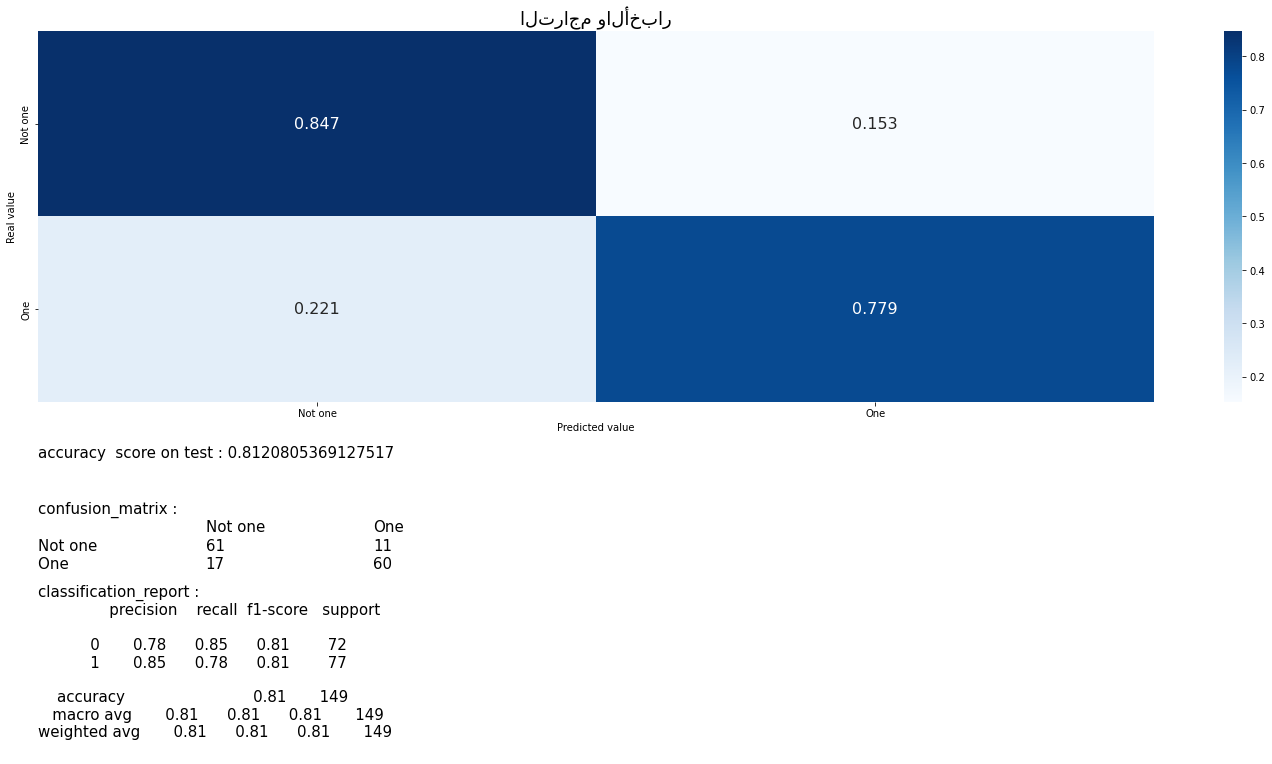

*******************************************************************************************
****************************** result for data التربية و الآداب ******************************
*******************************************************************************************
vectorizeation ....
training .....
evaluation ....
========== SVM ==========


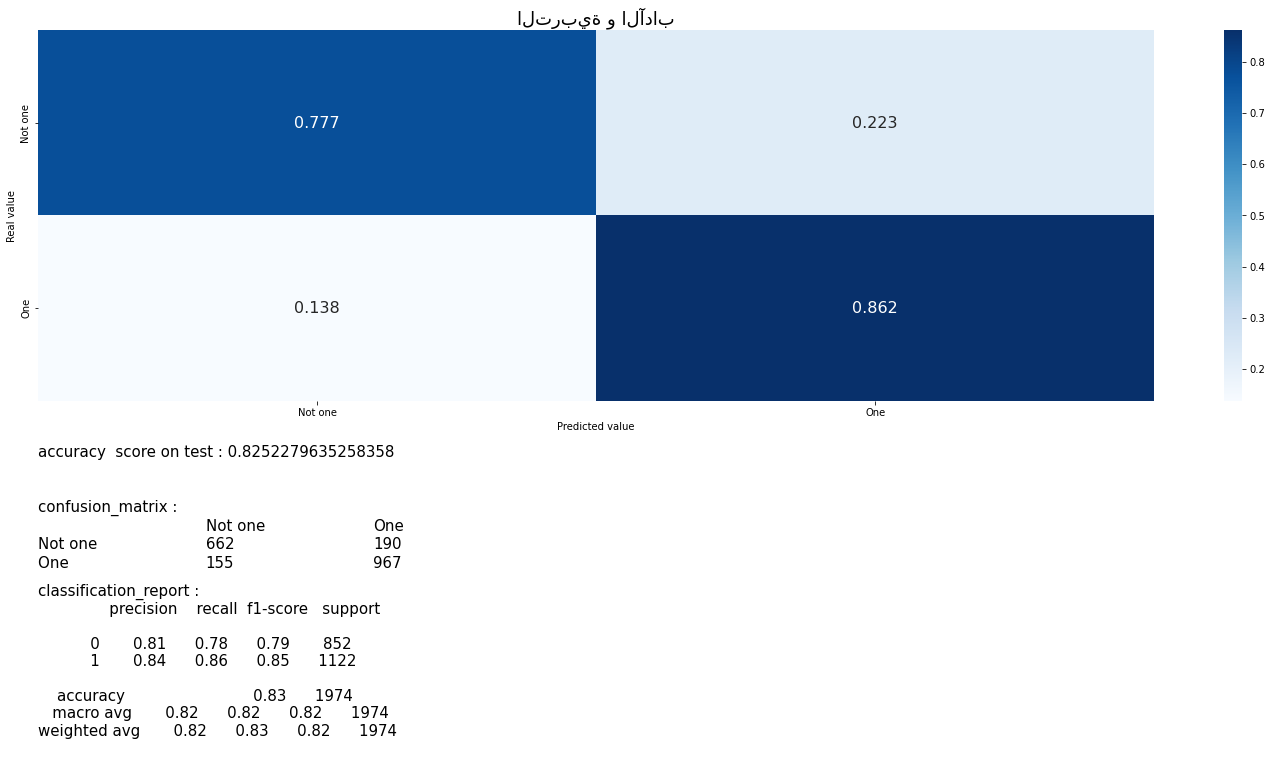

*******************************************************************************************
****************************** result for data القرآن و علومه ******************************
*******************************************************************************************
vectorizeation ....
training .....
evaluation ....
========== SVM ==========


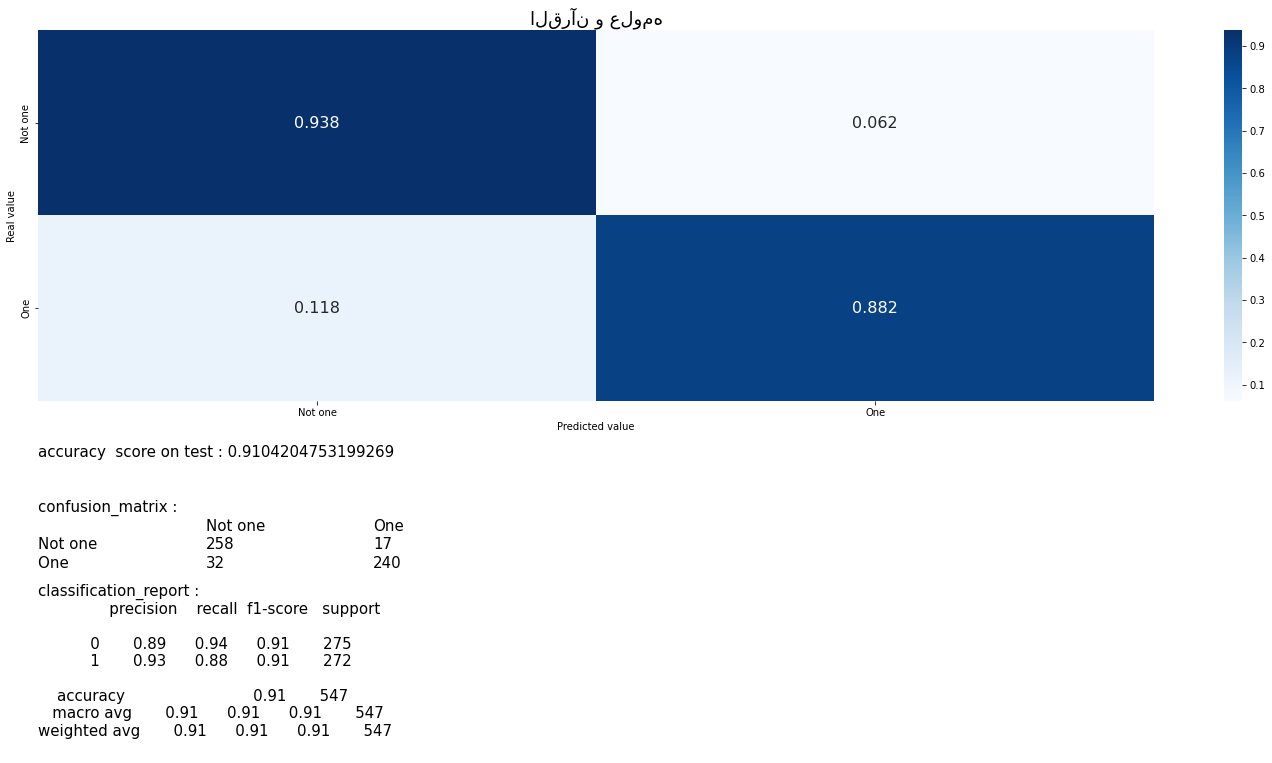

*******************************************************************************************
****************************** result for data السياسة الشرعية ******************************
*******************************************************************************************
vectorizeation ....
training .....
evaluation ....
========== SVM ==========


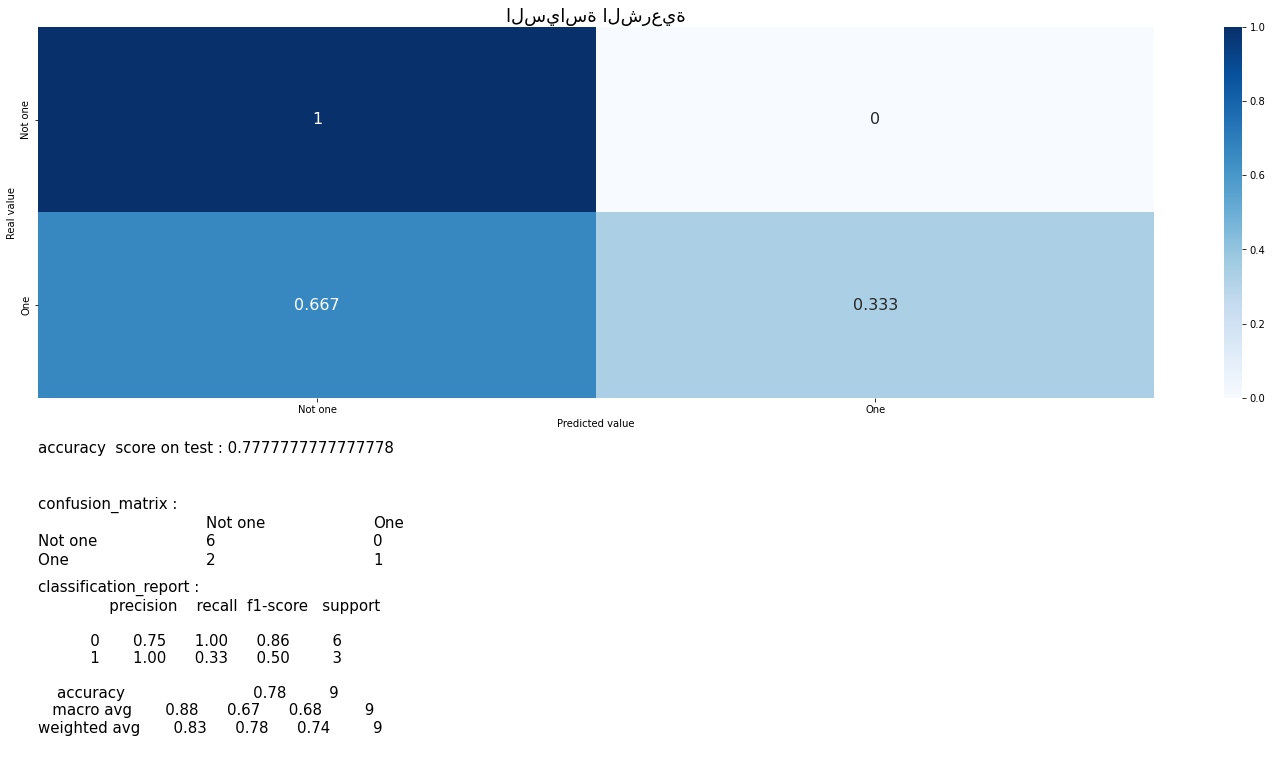

*******************************************************************************************
****************************** result for data التاريخ و السيرة النبوية ******************************
*******************************************************************************************
vectorizeation ....
training .....
evaluation ....
========== SVM ==========


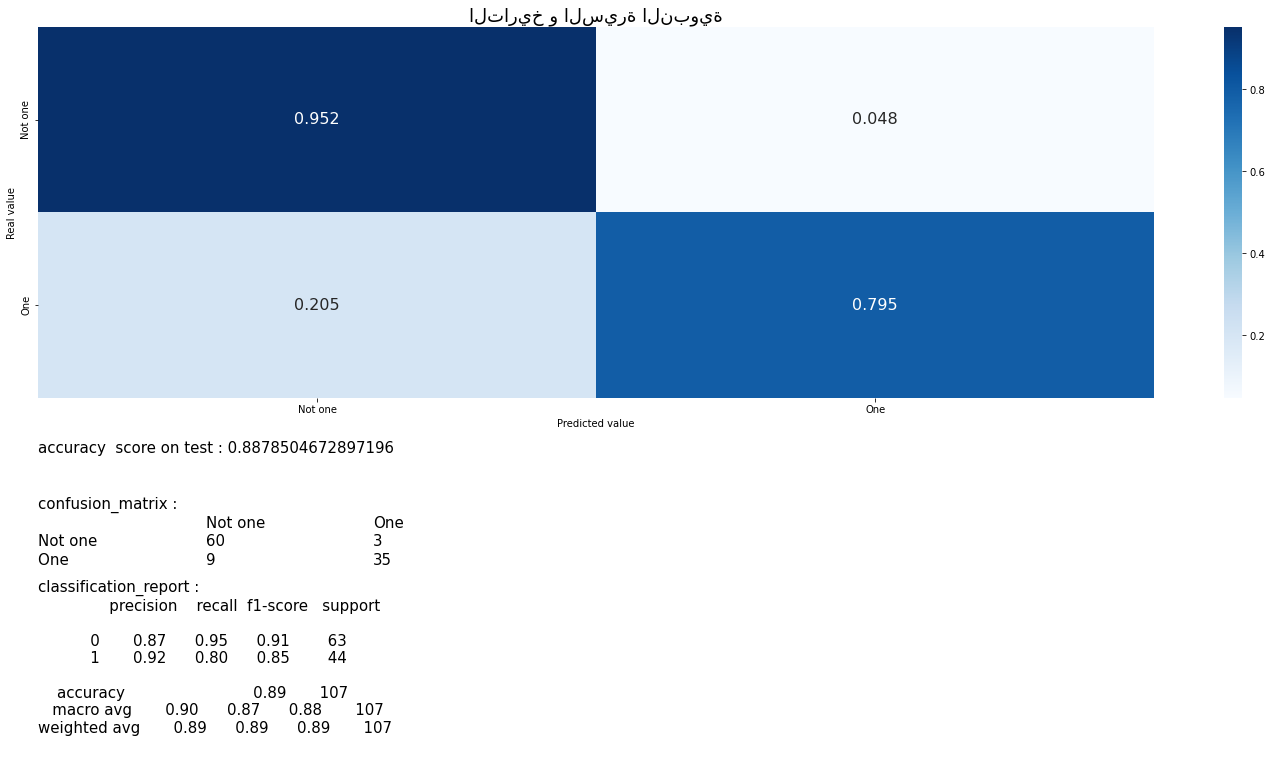

*******************************************************************************************
****************************** result for data العلم و الدعوة ******************************
*******************************************************************************************
vectorizeation ....
training .....
evaluation ....
========== SVM ==========


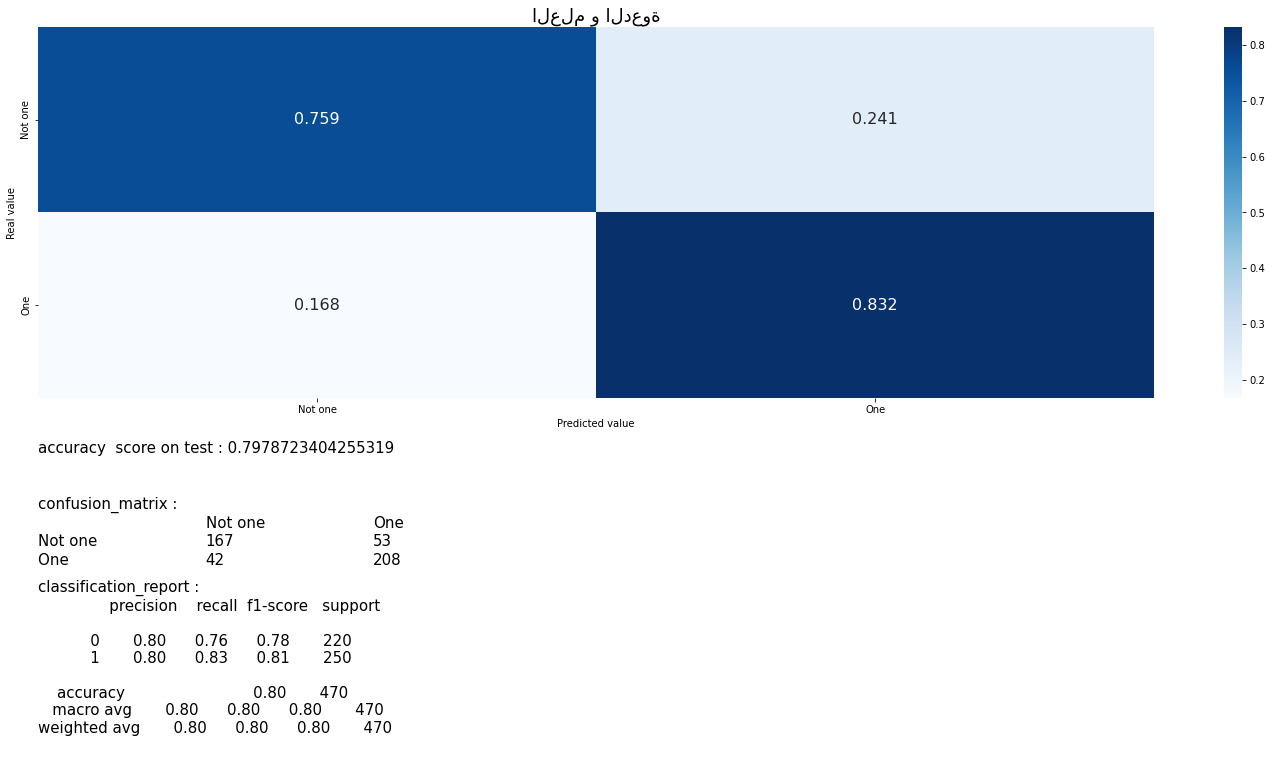

*******************************************************************************************
****************************** result for data العقيدة الإسلامية ******************************
*******************************************************************************************
vectorizeation ....
training .....
evaluation ....
========== SVM ==========


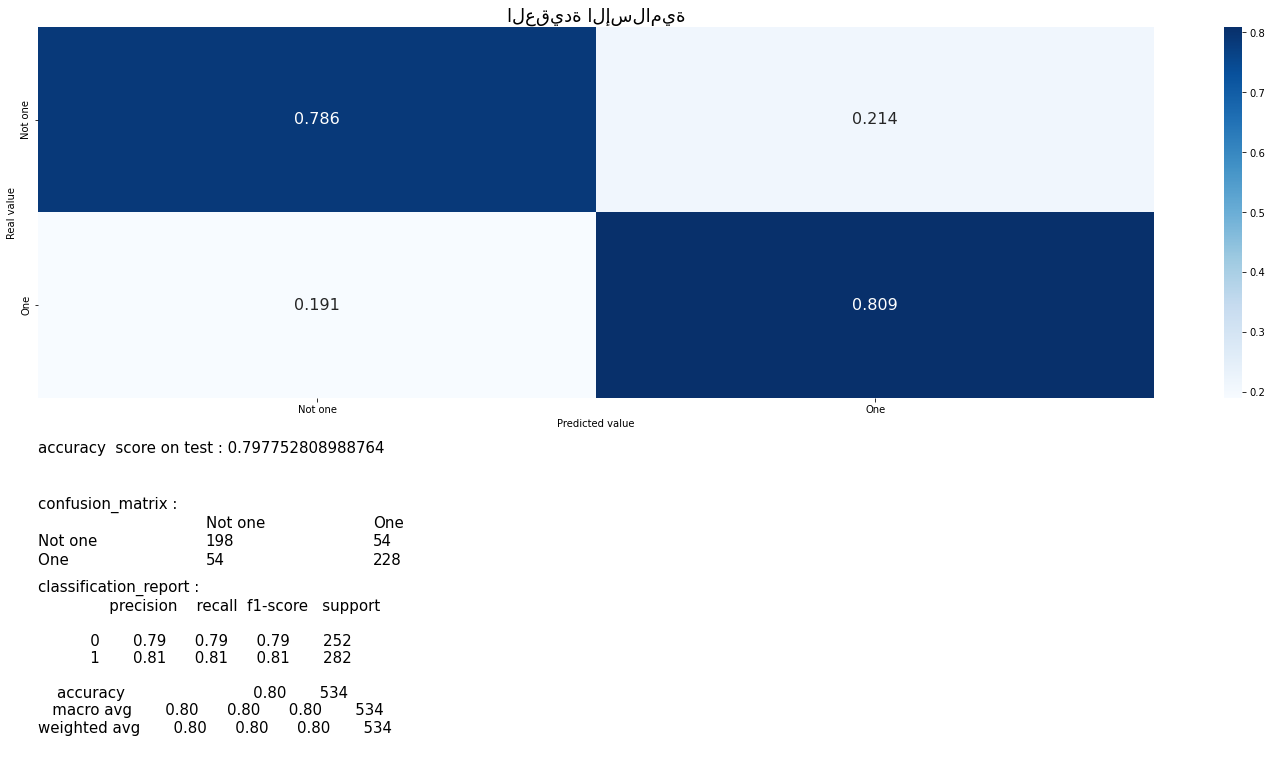

*******************************************************************************************
****************************** result for data الأذكار والأدعية ******************************
*******************************************************************************************
vectorizeation ....
training .....
evaluation ....
========== SVM ==========


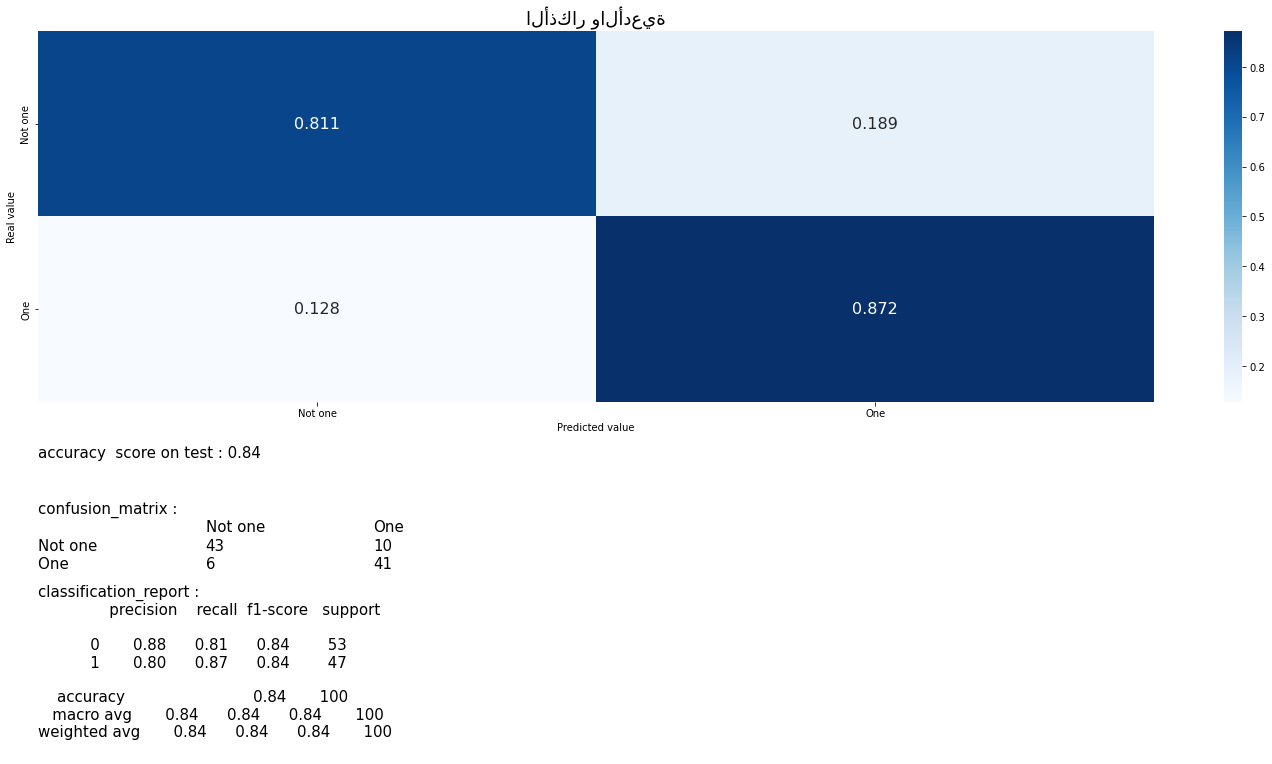

*******************************************************************************************
****************************** result for data مشكلات اجتماعية وفكرية ******************************
*******************************************************************************************
vectorizeation ....
training .....
evaluation ....
========== SVM ==========


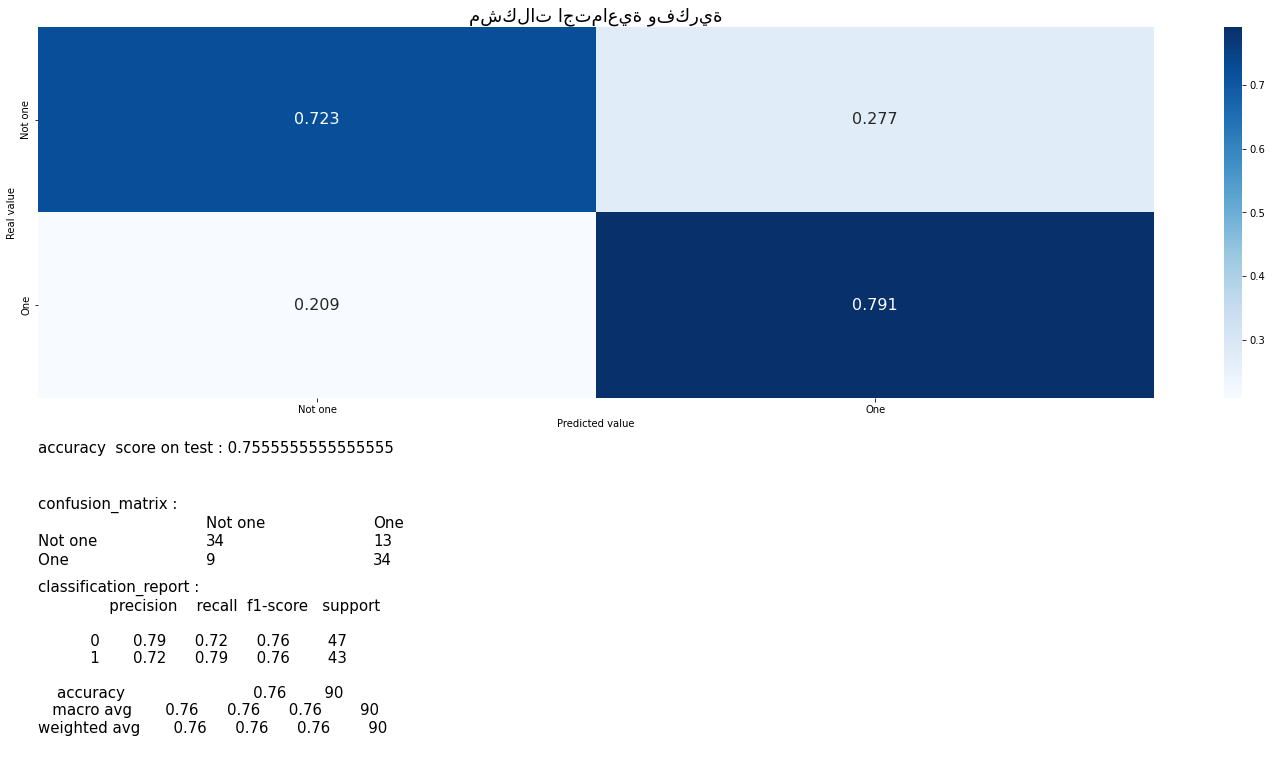

*******************************************************************************************
****************************** result for data الحديث الشريف ******************************
*******************************************************************************************
vectorizeation ....
training .....
evaluation ....
========== SVM ==========


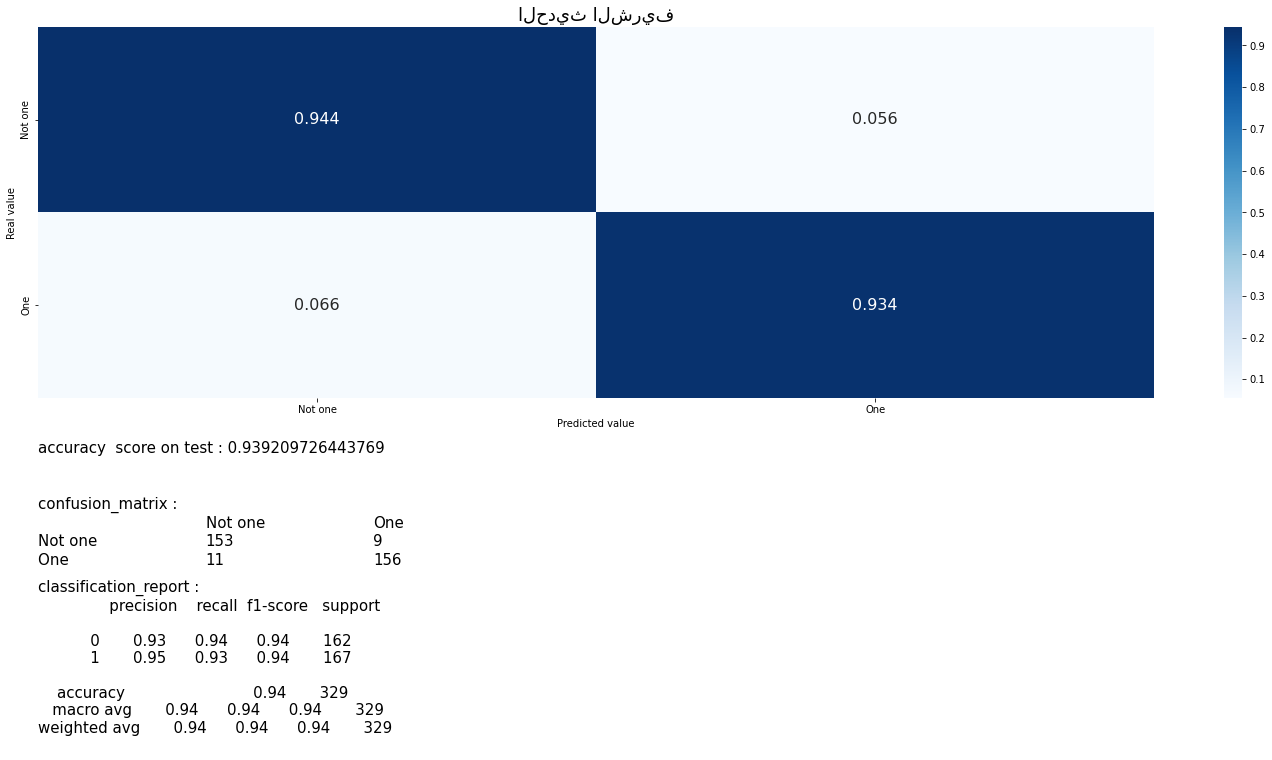

*******************************************************************************************
****************************** result for data الفقه وفروعه ******************************
*******************************************************************************************
vectorizeation ....
training .....
evaluation ....
========== SVM ==========


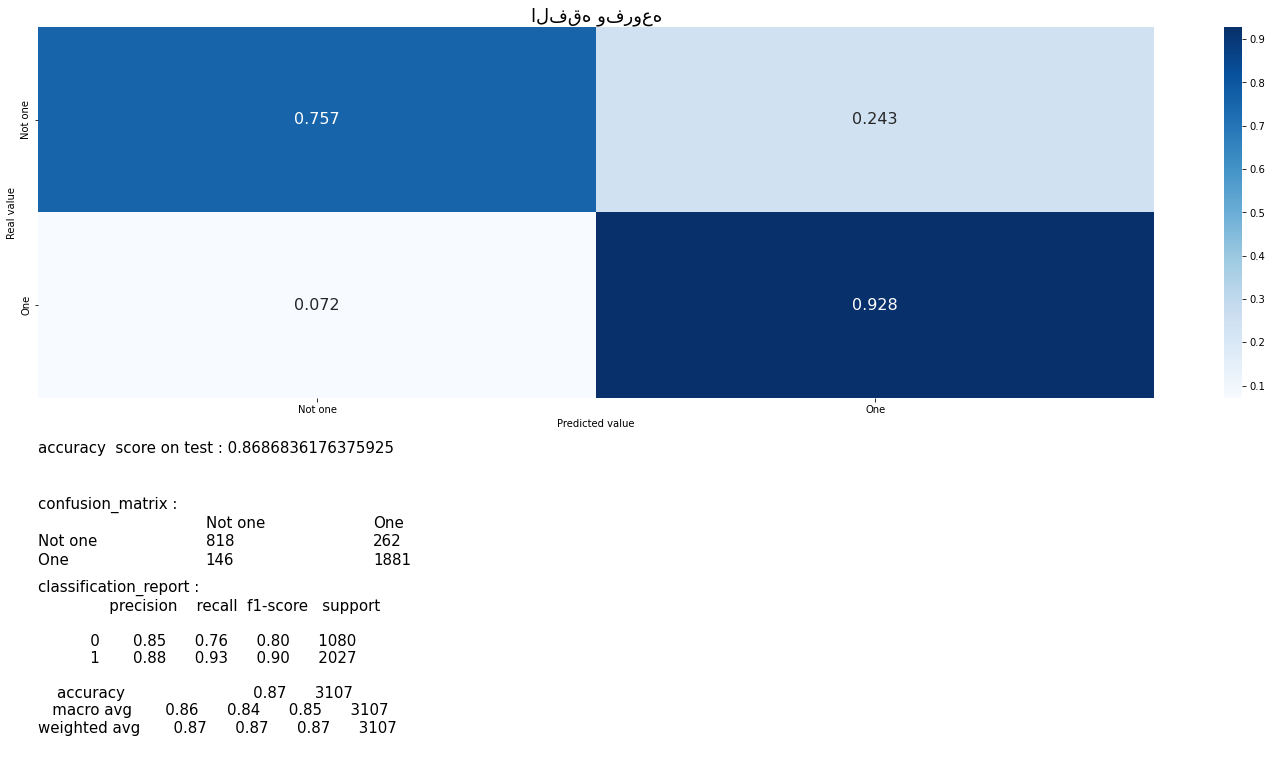

*******************************************************************************************
****************************** result for data الأطعمة والأشربة والصيد ******************************
*******************************************************************************************
vectorizeation ....
training .....
evaluation ....
========== SVM ==========


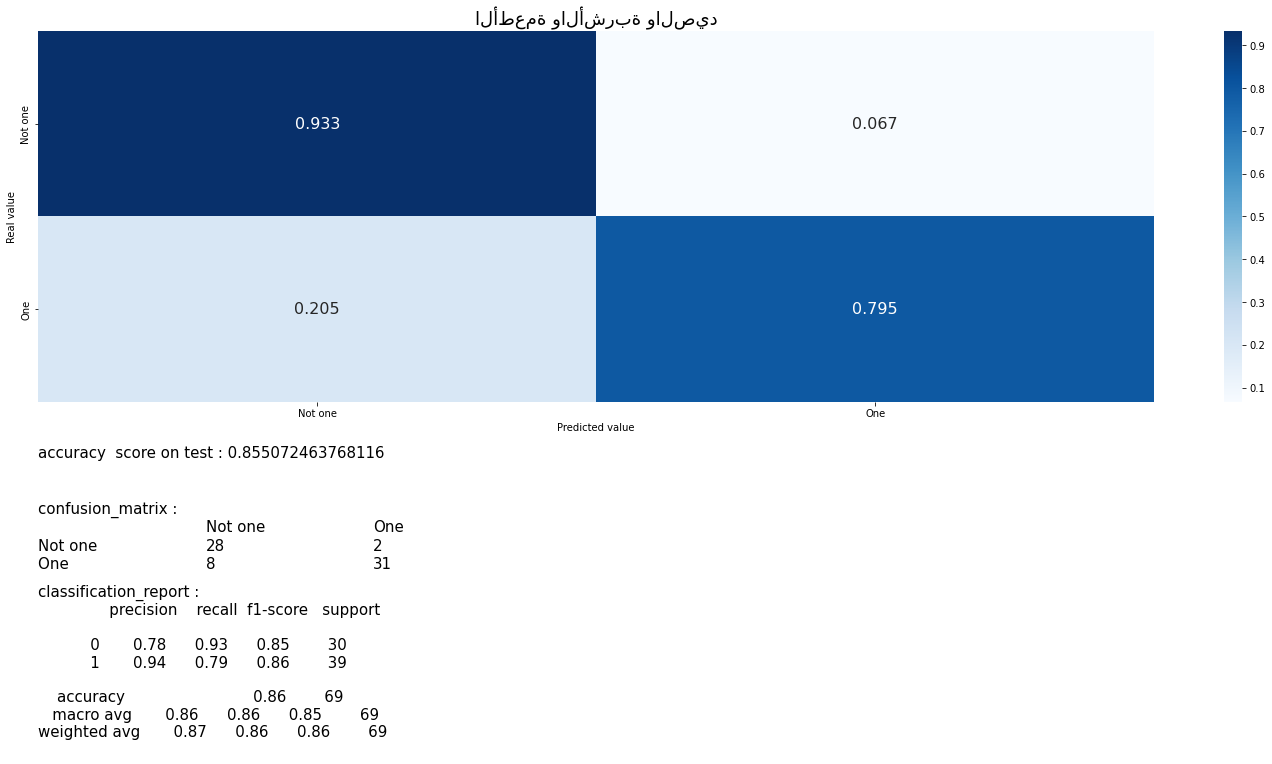

In [43]:
seq_Container_Result = Creat_Container_Result()
tokenizers = []
vectorizers = []
for i in range(len(X_train)):
    print("*******************************************************************************************")
    print("******************************","result for data",labels[i],"******************************")
    print("*******************************************************************************************")
    print("vectorizeation ....")

    v_X_tr , vectorizer = tfidf_vectorizer(X_train[i])
    vectorizers.append(vectorizer)
    v_X_te = vectorizer.transform(X_test[i])
    print("training .....")
    svm = train_models(v_X_tr,y_train[i],save_model,labels[i]) # X_tr, # ,Network,history
    print('evaluation ....')
    evaluate_result(svm,v_X_te,y_test[i],'SVM',labels[i],seq_Container_Result,None)

# Save_Load Results

In [44]:
def save_object(obj, filename):
    filename = os.path.join(results_path,filename)
    with open(filename+".pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()
def load_object(filename):
    filename = os.path.join(results_path,filename)
    with open(filename+".pkl", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

In [45]:
save_object(seq_Container_Result,"seq_Container_Result_v2")
save_object(save_model,"save_model_v2")


# seq_Container_Result = load_object('seq_Container_Result_v2')
# save_model = load_object('save_model_v2')

In [46]:
# save_object(tokenizers,"tokenizers_v2")
save_object(vectorizers,"vectorizers_v2")

# tokenizers = load_object('tokenizers_v2')
# vectorizers = load_object('vectorizers_v2')

# Select best model 

In [47]:
best_models = []
for i,label in enumerate(labels):
  best_models.append(save_model['SVM'][label][0])

In [48]:
save_object(best_models,'best_models_v2')
# best_models = load_object('best_models__')

In [49]:
new_X_test = []
new_Y_test = []
for i,Y_test in enumerate(y_test):
    x_temp = []
    y_temp = []
    for j,y in enumerate(Y_test):
        if y==1:
            y_temp.append(y)
            x_temp.append(X_test[i][j])
    new_Y_test.append(y_temp) 
    new_X_test.append(x_temp)

In [50]:
save_object(labels,"labels")
labels

['التراجم والأخبار',
 'التربية و الآداب',
 'القرآن و علومه',
 'السياسة الشرعية',
 'التاريخ و السيرة النبوية',
 'العلم و الدعوة',
 'العقيدة الإسلامية',
 'الأذكار والأدعية',
 'مشكلات اجتماعية وفكرية',
 'الحديث الشريف',
 'الفقه وفروعه',
 'الأطعمة والأشربة والصيد']

In [51]:
for i,X in enumerate(new_X_test):
  j=0
  print("*************************************************************************")
  print("*************************************************************************")
  for j,x in enumerate(X):
    best_pre = []
    print("===================================================================")
    print("Real Label :",labels[i])
    for m,model in enumerate(best_models):
      tx = vectorizers[m].transform([x])
      # tx = tokenizer.texts_to_sequences([x])
      # tx = pad_sequences(tx, padding='post', maxlen=maxlen)
      if model.predict(tx)[0]==1:
        print("Result Model : "+str(labels[m])+" =>",max(model.predict_proba(tx)[0]))
        best_pre.append(max(model.predict_proba(tx)[0]))
      else:
        print("Result Model : "+str(labels[m])+" =>",min(model.predict_proba(tx)[0]))
        best_pre.append(min(model.predict_proba(tx)[0]))
    
    print("***** predict =>",labels[best_pre.index(max(best_pre))],max(best_pre))

Streaming output truncated to the last 5000 lines.
Result Model : الفقه وفروعه => 0.01584316153111791
Result Model : الأطعمة والأشربة والصيد => 0.00031044803603403134
***** predict => القرآن و علومه 0.9999999999998499
Real Label : الفقه وفروعه
Result Model : التراجم والأخبار => 0.7369920168272247
Result Model : التربية و الآداب => 0.8639521352109268
Result Model : القرآن و علومه => 0.3843617372598854
Result Model : السياسة الشرعية => 0.5
Result Model : التاريخ و السيرة النبوية => 0.2156220685658512
Result Model : العلم و الدعوة => 0.26895532674706984
Result Model : العقيدة الإسلامية => 0.31001236590888154
Result Model : الأذكار والأدعية => 0.3409926914131301
Result Model : مشكلات اجتماعية وفكرية => 0.5838940460131292
Result Model : الحديث الشريف => 0.27652790602366323
Result Model : الفقه وفروعه => 0.6950398187420718
Result Model : الأطعمة والأشربة والصيد => 0.08958345603350266
***** predict => التربية و الآداب 0.8639521352109268
Real Label : الفقه وفروعه
Result Model : التراجم والأخبا

In [ ]:
# ******************************************************************

In [ ]:
best_models = []
for i,label in enumerate(labels):
  best_models.append(save_model['SVM'][label][0])

In [ ]:
save_object(best_models_SVM,'best_models_SVM')
# save_object(tokenizers_SVM,"tokenizers_SVM")

# best_models = load_object('best_models__')
# vectorizers = load_object('vectorizers')

In [ ]:
new_X_test = []
new_Y_test = []
for i,Y_test in enumerate(y_test):
    x_temp = []
    y_temp = []
    for j,y in enumerate(Y_test):
        if y==1:
            y_temp.append(y)
            x_temp.append(X_test[i][j])
    new_Y_test.append(y_temp) 
    new_X_test.append(x_temp)

In [ ]:
save_object(labels,"labels")
labels

In [ ]:
# X_te = tokenizer.texts_to_sequences(X_test[i])
# X_te = pad_sequences(X_te, padding='post', maxlen=maxlen)

In [ ]:
for i,X in enumerate(new_X_test):
  j=0
  print("*************************************************************************")
  print("*************************************************************************")
  for j,x in enumerate(X):
    best_pre = []
    print("===================================================================")
    print("Real Label :",labels[i])
    for m,model in enumerate(best_models_SVM):
      # tx = vectorizers[m].transform([x])
      tx = tokenizers_SVM.texts_to_sequences([x])
      tx = pad_sequences(tx, padding='post', maxlen=maxlen)
      if model.predict(tx)[0]==1:
        print("Result Model : "+str(labels[m])+" =>",max(model.predict_proba(tx)[0]))
        best_pre.append(max(model.predict_proba(tx)[0]))
      else:
        print("Result Model : "+str(labels[m])+" =>",min(model.predict_proba(tx)[0]))
        best_pre.append(min(model.predict_proba(tx)[0]))
    
    print("***** predict =>",labels[best_pre.index(max(best_pre))],max(best_pre))